In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 184)
(772408, 8)
validation
(101248, 184)
(101248, 8)
test
(98888, 184)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 879496 (3.36 MB)


Trainable params: 879496 (3.36 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:37 - loss: 1.8930 - STD: 0.0622 - MAE: 0.2108

 7/78 [=>............................] - ETA: 0s - loss: 1.4622 - STD: 0.1854 - MAE: 0.1509  

13/78 [====>.........................] - ETA: 0s - loss: 1.4115 - STD: 0.1895 - MAE: 0.1482

19/78 [======>.......................] - ETA: 0s - loss: 1.3850 - STD: 0.1905 - MAE: 0.1471

25/78 [========>.....................] - ETA: 0s - loss: 1.3716 - STD: 0.1935 - MAE: 0.1457

31/78 [==========>...................] - ETA: 0s - loss: 1.3618 - STD: 0.1913 - MAE: 0.1464

35/78 [============>.................] - ETA: 1s - loss: 1.3570 - STD: 0.1909 - MAE: 0.1464

41/78 [==============>...............] - ETA: 0s - loss: 1.3516 - STD: 0.1918 - MAE: 0.1460

47/78 [=================>............] - ETA: 0s - loss: 1.3474 - STD: 0.1915 - MAE: 0.1460

53/78 [===================>..........] - ETA: 0s - loss: 1.3440 - STD: 0.1913 - MAE: 0.1460

59/78 [=====================>........] - ETA: 0s - loss: 1.3415 - STD: 0.1915 - MAE: 0.1459

65/78 [========================>.....] - ETA: 0s - loss: 1.3386 - STD: 0.1915 - MAE: 0.1458

71/78 [==========================>...] - ETA: 0s - loss: 1.3364 - STD: 0.1916 - MAE: 0.1457

77/78 [============================>.] - ETA: 0s - loss: 1.3349 - STD: 0.1916 - MAE: 0.1457

78/78 [==============================] - 3s 26ms/step - loss: 1.3347 - STD: 0.1915 - MAE: 0.1457 - val_loss: 1.2744 - val_STD: 0.1902 - val_MAE: 0.1455


Epoch 2/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3158 - STD: 0.1902 - MAE: 0.1460

 7/78 [=>............................] - ETA: 0s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1454

13/78 [====>.........................] - ETA: 0s - loss: 1.3171 - STD: 0.1914 - MAE: 0.1454

19/78 [======>.......................] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1453

25/78 [========>.....................] - ETA: 0s - loss: 1.3146 - STD: 0.1917 - MAE: 0.1452

32/78 [===========>..................] - ETA: 0s - loss: 1.3160 - STD: 0.1917 - MAE: 0.1453

38/78 [=============>................] - ETA: 0s - loss: 1.3161 - STD: 0.1917 - MAE: 0.1453

44/78 [===============>..............] - ETA: 0s - loss: 1.3155 - STD: 0.1915 - MAE: 0.1453

50/78 [==================>...........] - ETA: 0s - loss: 1.3161 - STD: 0.1915 - MAE: 0.1453

56/78 [====================>.........] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3162 - STD: 0.1913 - MAE: 0.1454

68/78 [=========================>....] - ETA: 0s - loss: 1.3153 - STD: 0.1915 - MAE: 0.1453

74/78 [===========================>..] - ETA: 0s - loss: 1.3152 - STD: 0.1914 - MAE: 0.1454

78/78 [==============================] - 1s 10ms/step - loss: 1.3145 - STD: 0.1914 - MAE: 0.1453 - val_loss: 1.2651 - val_STD: 0.1960 - val_MAE: 0.1428


Epoch 3/10000


 1/78 [..............................] - ETA: 1s - loss: 1.3115 - STD: 0.1935 - MAE: 0.1445

 7/78 [=>............................] - ETA: 0s - loss: 1.3054 - STD: 0.1910 - MAE: 0.1450

13/78 [====>.........................] - ETA: 0s - loss: 1.3006 - STD: 0.1915 - MAE: 0.1445

19/78 [======>.......................] - ETA: 0s - loss: 1.2974 - STD: 0.1918 - MAE: 0.1443

25/78 [========>.....................] - ETA: 0s - loss: 1.2969 - STD: 0.1924 - MAE: 0.1440

31/78 [==========>...................] - ETA: 0s - loss: 1.2949 - STD: 0.1927 - MAE: 0.1438

37/78 [=============>................] - ETA: 0s - loss: 1.2931 - STD: 0.1928 - MAE: 0.1437

43/78 [===============>..............] - ETA: 0s - loss: 1.2912 - STD: 0.1933 - MAE: 0.1435

49/78 [=================>............] - ETA: 0s - loss: 1.2895 - STD: 0.1933 - MAE: 0.1434

56/78 [====================>.........] - ETA: 0s - loss: 1.2871 - STD: 0.1936 - MAE: 0.1433

62/78 [======================>.......] - ETA: 0s - loss: 1.2850 - STD: 0.1937 - MAE: 0.1432

68/78 [=========================>....] - ETA: 0s - loss: 1.2822 - STD: 0.1939 - MAE: 0.1431

74/78 [===========================>..] - ETA: 0s - loss: 1.2796 - STD: 0.1940 - MAE: 0.1430

78/78 [==============================] - 1s 10ms/step - loss: 1.2780 - STD: 0.1940 - MAE: 0.1429 - val_loss: 1.2045 - val_STD: 0.1952 - val_MAE: 0.1413


Epoch 4/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2352 - STD: 0.1938 - MAE: 0.1417

 7/78 [=>............................] - ETA: 0s - loss: 1.2408 - STD: 0.1961 - MAE: 0.1413

13/78 [====>.........................] - ETA: 0s - loss: 1.2364 - STD: 0.1962 - MAE: 0.1411

19/78 [======>.......................] - ETA: 0s - loss: 1.2326 - STD: 0.1964 - MAE: 0.1408

25/78 [========>.....................] - ETA: 0s - loss: 1.2306 - STD: 0.1968 - MAE: 0.1406

31/78 [==========>...................] - ETA: 0s - loss: 1.2284 - STD: 0.1970 - MAE: 0.1405

37/78 [=============>................] - ETA: 0s - loss: 1.2276 - STD: 0.1970 - MAE: 0.1404

43/78 [===============>..............] - ETA: 0s - loss: 1.2264 - STD: 0.1970 - MAE: 0.1404

49/78 [=================>............] - ETA: 0s - loss: 1.2251 - STD: 0.1974 - MAE: 0.1402

55/78 [====================>.........] - ETA: 0s - loss: 1.2239 - STD: 0.1975 - MAE: 0.1401

62/78 [======================>.......] - ETA: 0s - loss: 1.2222 - STD: 0.1977 - MAE: 0.1400

68/78 [=========================>....] - ETA: 0s - loss: 1.2212 - STD: 0.1979 - MAE: 0.1399

74/78 [===========================>..] - ETA: 0s - loss: 1.2198 - STD: 0.1980 - MAE: 0.1398

78/78 [==============================] - 1s 10ms/step - loss: 1.2189 - STD: 0.1982 - MAE: 0.1397 - val_loss: 1.1610 - val_STD: 0.1970 - val_MAE: 0.1391


Epoch 5/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2068 - STD: 0.1933 - MAE: 0.1408

 7/78 [=>............................] - ETA: 0s - loss: 1.2017 - STD: 0.1990 - MAE: 0.1388

13/78 [====>.........................] - ETA: 0s - loss: 1.2022 - STD: 0.2001 - MAE: 0.1384

19/78 [======>.......................] - ETA: 0s - loss: 1.2006 - STD: 0.2004 - MAE: 0.1382

26/78 [=========>....................] - ETA: 0s - loss: 1.1996 - STD: 0.2007 - MAE: 0.1380

32/78 [===========>..................] - ETA: 0s - loss: 1.1996 - STD: 0.2007 - MAE: 0.1381

38/78 [=============>................] - ETA: 0s - loss: 1.1991 - STD: 0.2007 - MAE: 0.1380

44/78 [===============>..............] - ETA: 0s - loss: 1.1997 - STD: 0.2005 - MAE: 0.1382

50/78 [==================>...........] - ETA: 0s - loss: 1.1985 - STD: 0.2006 - MAE: 0.1381

56/78 [====================>.........] - ETA: 0s - loss: 1.1975 - STD: 0.2007 - MAE: 0.1380

62/78 [======================>.......] - ETA: 0s - loss: 1.1968 - STD: 0.2008 - MAE: 0.1379

68/78 [=========================>....] - ETA: 0s - loss: 1.1967 - STD: 0.2009 - MAE: 0.1379

74/78 [===========================>..] - ETA: 0s - loss: 1.1960 - STD: 0.2010 - MAE: 0.1378

78/78 [==============================] - 1s 10ms/step - loss: 1.1953 - STD: 0.2010 - MAE: 0.1378 - val_loss: 1.1472 - val_STD: 0.2115 - val_MAE: 0.1329


Epoch 6/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1813 - STD: 0.2063 - MAE: 0.1349

 7/78 [=>............................] - ETA: 0s - loss: 1.1864 - STD: 0.2019 - MAE: 0.1370

13/78 [====>.........................] - ETA: 0s - loss: 1.1918 - STD: 0.2012 - MAE: 0.1376

19/78 [======>.......................] - ETA: 0s - loss: 1.1915 - STD: 0.2013 - MAE: 0.1376

25/78 [========>.....................] - ETA: 0s - loss: 1.1896 - STD: 0.2017 - MAE: 0.1373

31/78 [==========>...................] - ETA: 0s - loss: 1.1879 - STD: 0.2017 - MAE: 0.1372

37/78 [=============>................] - ETA: 0s - loss: 1.1866 - STD: 0.2017 - MAE: 0.1372

43/78 [===============>..............] - ETA: 0s - loss: 1.1853 - STD: 0.2017 - MAE: 0.1371

49/78 [=================>............] - ETA: 0s - loss: 1.1836 - STD: 0.2019 - MAE: 0.1369

55/78 [====================>.........] - ETA: 0s - loss: 1.1845 - STD: 0.2020 - MAE: 0.1369

62/78 [======================>.......] - ETA: 0s - loss: 1.1836 - STD: 0.2021 - MAE: 0.1369

68/78 [=========================>....] - ETA: 0s - loss: 1.1824 - STD: 0.2021 - MAE: 0.1368

74/78 [===========================>..] - ETA: 0s - loss: 1.1817 - STD: 0.2022 - MAE: 0.1367

78/78 [==============================] - 1s 10ms/step - loss: 1.1806 - STD: 0.2023 - MAE: 0.1367 - val_loss: 1.1394 - val_STD: 0.2046 - val_MAE: 0.1350


Epoch 7/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1744 - STD: 0.2015 - MAE: 0.1372

 8/78 [==>...........................] - ETA: 0s - loss: 1.1682 - STD: 0.2036 - MAE: 0.1356

14/78 [====>.........................] - ETA: 0s - loss: 1.1682 - STD: 0.2037 - MAE: 0.1356

20/78 [======>.......................] - ETA: 0s - loss: 1.1688 - STD: 0.2034 - MAE: 0.1357

26/78 [=========>....................] - ETA: 0s - loss: 1.1676 - STD: 0.2034 - MAE: 0.1357

32/78 [===========>..................] - ETA: 0s - loss: 1.1655 - STD: 0.2035 - MAE: 0.1355

38/78 [=============>................] - ETA: 0s - loss: 1.1638 - STD: 0.2037 - MAE: 0.1354

44/78 [===============>..............] - ETA: 0s - loss: 1.1635 - STD: 0.2037 - MAE: 0.1354

50/78 [==================>...........] - ETA: 0s - loss: 1.1629 - STD: 0.2037 - MAE: 0.1353

56/78 [====================>.........] - ETA: 0s - loss: 1.1621 - STD: 0.2038 - MAE: 0.1353

62/78 [======================>.......] - ETA: 0s - loss: 1.1622 - STD: 0.2038 - MAE: 0.1353

68/78 [=========================>....] - ETA: 0s - loss: 1.1613 - STD: 0.2038 - MAE: 0.1353

74/78 [===========================>..] - ETA: 0s - loss: 1.1606 - STD: 0.2039 - MAE: 0.1353

78/78 [==============================] - 1s 10ms/step - loss: 1.1609 - STD: 0.2039 - MAE: 0.1353 - val_loss: 1.1384 - val_STD: 0.2041 - val_MAE: 0.1352


Epoch 8/10000


 1/78 [..............................] - ETA: 1s - loss: 1.1627 - STD: 0.2038 - MAE: 0.1357

 7/78 [=>............................] - ETA: 0s - loss: 1.1528 - STD: 0.2050 - MAE: 0.1347

13/78 [====>.........................] - ETA: 0s - loss: 1.1481 - STD: 0.2047 - MAE: 0.1347

19/78 [======>.......................] - ETA: 0s - loss: 1.1495 - STD: 0.2045 - MAE: 0.1348

25/78 [========>.....................] - ETA: 0s - loss: 1.1484 - STD: 0.2044 - MAE: 0.1348

31/78 [==========>...................] - ETA: 0s - loss: 1.1485 - STD: 0.2044 - MAE: 0.1348

37/78 [=============>................] - ETA: 0s - loss: 1.1474 - STD: 0.2044 - MAE: 0.1348

43/78 [===============>..............] - ETA: 0s - loss: 1.1460 - STD: 0.2047 - MAE: 0.1347

49/78 [=================>............] - ETA: 0s - loss: 1.1447 - STD: 0.2049 - MAE: 0.1345

55/78 [====================>.........] - ETA: 0s - loss: 1.1447 - STD: 0.2049 - MAE: 0.1345

61/78 [======================>.......] - ETA: 0s - loss: 1.1429 - STD: 0.2049 - MAE: 0.1344

67/78 [========================>.....] - ETA: 0s - loss: 1.1417 - STD: 0.2051 - MAE: 0.1343

74/78 [===========================>..] - ETA: 0s - loss: 1.1411 - STD: 0.2053 - MAE: 0.1342

78/78 [==============================] - 1s 10ms/step - loss: 1.1408 - STD: 0.2051 - MAE: 0.1343 - val_loss: 1.1187 - val_STD: 0.2071 - val_MAE: 0.1331


Epoch 9/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1148 - STD: 0.2087 - MAE: 0.1316

 7/78 [=>............................] - ETA: 0s - loss: 1.1294 - STD: 0.2065 - MAE: 0.1332

13/78 [====>.........................] - ETA: 0s - loss: 1.1311 - STD: 0.2058 - MAE: 0.1336

19/78 [======>.......................] - ETA: 0s - loss: 1.1298 - STD: 0.2059 - MAE: 0.1335

25/78 [========>.....................] - ETA: 0s - loss: 1.1309 - STD: 0.2058 - MAE: 0.1336

31/78 [==========>...................] - ETA: 0s - loss: 1.1303 - STD: 0.2059 - MAE: 0.1336

37/78 [=============>................] - ETA: 0s - loss: 1.1295 - STD: 0.2058 - MAE: 0.1336

43/78 [===============>..............] - ETA: 0s - loss: 1.1293 - STD: 0.2059 - MAE: 0.1336

49/78 [=================>............] - ETA: 0s - loss: 1.1290 - STD: 0.2059 - MAE: 0.1336

55/78 [====================>.........] - ETA: 0s - loss: 1.1296 - STD: 0.2059 - MAE: 0.1336

61/78 [======================>.......] - ETA: 0s - loss: 1.1295 - STD: 0.2058 - MAE: 0.1337

67/78 [========================>.....] - ETA: 0s - loss: 1.1282 - STD: 0.2059 - MAE: 0.1336

73/78 [===========================>..] - ETA: 0s - loss: 1.1278 - STD: 0.2060 - MAE: 0.1335

78/78 [==============================] - 1s 11ms/step - loss: 1.1265 - STD: 0.2062 - MAE: 0.1334 - val_loss: 1.1071 - val_STD: 0.2081 - val_MAE: 0.1323


Epoch 10/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1167 - STD: 0.2089 - MAE: 0.1319

 8/78 [==>...........................] - ETA: 0s - loss: 1.1169 - STD: 0.2072 - MAE: 0.1324

14/78 [====>.........................] - ETA: 0s - loss: 1.1195 - STD: 0.2072 - MAE: 0.1326

20/78 [======>.......................] - ETA: 0s - loss: 1.1203 - STD: 0.2071 - MAE: 0.1328

26/78 [=========>....................] - ETA: 0s - loss: 1.1211 - STD: 0.2067 - MAE: 0.1329

32/78 [===========>..................] - ETA: 0s - loss: 1.1212 - STD: 0.2067 - MAE: 0.1330

38/78 [=============>................] - ETA: 0s - loss: 1.1196 - STD: 0.2070 - MAE: 0.1328

44/78 [===============>..............] - ETA: 0s - loss: 1.1192 - STD: 0.2069 - MAE: 0.1328

50/78 [==================>...........] - ETA: 0s - loss: 1.1191 - STD: 0.2069 - MAE: 0.1328

56/78 [====================>.........] - ETA: 0s - loss: 1.1191 - STD: 0.2068 - MAE: 0.1329

62/78 [======================>.......] - ETA: 0s - loss: 1.1185 - STD: 0.2069 - MAE: 0.1328

68/78 [=========================>....] - ETA: 0s - loss: 1.1177 - STD: 0.2071 - MAE: 0.1327

74/78 [===========================>..] - ETA: 0s - loss: 1.1173 - STD: 0.2071 - MAE: 0.1327

78/78 [==============================] - 1s 10ms/step - loss: 1.1170 - STD: 0.2071 - MAE: 0.1326 - val_loss: 1.1054 - val_STD: 0.2120 - val_MAE: 0.1307


Epoch 11/10000


 1/78 [..............................] - ETA: 1s - loss: 1.1253 - STD: 0.2120 - MAE: 0.1312

 7/78 [=>............................] - ETA: 0s - loss: 1.1123 - STD: 0.2070 - MAE: 0.1324

13/78 [====>.........................] - ETA: 0s - loss: 1.1171 - STD: 0.2074 - MAE: 0.1326

19/78 [======>.......................] - ETA: 0s - loss: 1.1147 - STD: 0.2067 - MAE: 0.1328

26/78 [=========>....................] - ETA: 0s - loss: 1.1135 - STD: 0.2070 - MAE: 0.1326

32/78 [===========>..................] - ETA: 0s - loss: 1.1125 - STD: 0.2073 - MAE: 0.1325

38/78 [=============>................] - ETA: 0s - loss: 1.1124 - STD: 0.2073 - MAE: 0.1324

44/78 [===============>..............] - ETA: 0s - loss: 1.1112 - STD: 0.2074 - MAE: 0.1323

50/78 [==================>...........] - ETA: 0s - loss: 1.1113 - STD: 0.2076 - MAE: 0.1322

56/78 [====================>.........] - ETA: 0s - loss: 1.1107 - STD: 0.2075 - MAE: 0.1323

62/78 [======================>.......] - ETA: 0s - loss: 1.1102 - STD: 0.2078 - MAE: 0.1321

68/78 [=========================>....] - ETA: 0s - loss: 1.1096 - STD: 0.2079 - MAE: 0.1321

74/78 [===========================>..] - ETA: 0s - loss: 1.1093 - STD: 0.2079 - MAE: 0.1321

78/78 [==============================] - 1s 10ms/step - loss: 1.1093 - STD: 0.2078 - MAE: 0.1321 - val_loss: 1.1139 - val_STD: 0.2075 - val_MAE: 0.1325


Epoch 12/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0953 - STD: 0.2073 - MAE: 0.1318

 7/78 [=>............................] - ETA: 0s - loss: 1.1000 - STD: 0.2092 - MAE: 0.1309

14/78 [====>.........................] - ETA: 0s - loss: 1.1066 - STD: 0.2074 - MAE: 0.1322

20/78 [======>.......................] - ETA: 0s - loss: 1.1070 - STD: 0.2075 - MAE: 0.1322

26/78 [=========>....................] - ETA: 0s - loss: 1.1061 - STD: 0.2079 - MAE: 0.1320

32/78 [===========>..................] - ETA: 0s - loss: 1.1050 - STD: 0.2080 - MAE: 0.1319

38/78 [=============>................] - ETA: 0s - loss: 1.1050 - STD: 0.2080 - MAE: 0.1319

44/78 [===============>..............] - ETA: 0s - loss: 1.1046 - STD: 0.2081 - MAE: 0.1318

50/78 [==================>...........] - ETA: 0s - loss: 1.1048 - STD: 0.2080 - MAE: 0.1319

56/78 [====================>.........] - ETA: 0s - loss: 1.1045 - STD: 0.2082 - MAE: 0.1318

62/78 [======================>.......] - ETA: 0s - loss: 1.1034 - STD: 0.2083 - MAE: 0.1317

68/78 [=========================>....] - ETA: 0s - loss: 1.1030 - STD: 0.2083 - MAE: 0.1316

74/78 [===========================>..] - ETA: 0s - loss: 1.1033 - STD: 0.2083 - MAE: 0.1317

78/78 [==============================] - 1s 10ms/step - loss: 1.1033 - STD: 0.2084 - MAE: 0.1316 - val_loss: 1.1078 - val_STD: 0.2046 - val_MAE: 0.1336


Epoch 13/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0920 - STD: 0.2058 - MAE: 0.1324

 8/78 [==>...........................] - ETA: 0s - loss: 1.0971 - STD: 0.2086 - MAE: 0.1312

14/78 [====>.........................] - ETA: 0s - loss: 1.1007 - STD: 0.2085 - MAE: 0.1314

20/78 [======>.......................] - ETA: 0s - loss: 1.1018 - STD: 0.2085 - MAE: 0.1315

26/78 [=========>....................] - ETA: 0s - loss: 1.1016 - STD: 0.2082 - MAE: 0.1316

32/78 [===========>..................] - ETA: 0s - loss: 1.1009 - STD: 0.2087 - MAE: 0.1314

38/78 [=============>................] - ETA: 0s - loss: 1.0995 - STD: 0.2089 - MAE: 0.1312

44/78 [===============>..............] - ETA: 0s - loss: 1.0995 - STD: 0.2088 - MAE: 0.1313

50/78 [==================>...........] - ETA: 0s - loss: 1.0985 - STD: 0.2089 - MAE: 0.1312

56/78 [====================>.........] - ETA: 0s - loss: 1.0984 - STD: 0.2088 - MAE: 0.1312

62/78 [======================>.......] - ETA: 0s - loss: 1.0982 - STD: 0.2090 - MAE: 0.1311

68/78 [=========================>....] - ETA: 0s - loss: 1.0982 - STD: 0.2089 - MAE: 0.1312

74/78 [===========================>..] - ETA: 0s - loss: 1.0982 - STD: 0.2089 - MAE: 0.1312

78/78 [==============================] - 1s 10ms/step - loss: 1.0984 - STD: 0.2089 - MAE: 0.1312 - val_loss: 1.1112 - val_STD: 0.2035 - val_MAE: 0.1340


Epoch 14/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0841 - STD: 0.2044 - MAE: 0.1323

 7/78 [=>............................] - ETA: 0s - loss: 1.0980 - STD: 0.2088 - MAE: 0.1313

13/78 [====>.........................] - ETA: 0s - loss: 1.0940 - STD: 0.2085 - MAE: 0.1312

19/78 [======>.......................] - ETA: 0s - loss: 1.0937 - STD: 0.2090 - MAE: 0.1310

25/78 [========>.....................] - ETA: 0s - loss: 1.0920 - STD: 0.2092 - MAE: 0.1308

31/78 [==========>...................] - ETA: 0s - loss: 1.0924 - STD: 0.2092 - MAE: 0.1309

37/78 [=============>................] - ETA: 0s - loss: 1.0928 - STD: 0.2091 - MAE: 0.1309

43/78 [===============>..............] - ETA: 0s - loss: 1.0931 - STD: 0.2092 - MAE: 0.1309

49/78 [=================>............] - ETA: 0s - loss: 1.0936 - STD: 0.2094 - MAE: 0.1308

55/78 [====================>.........] - ETA: 0s - loss: 1.0945 - STD: 0.2093 - MAE: 0.1309

61/78 [======================>.......] - ETA: 0s - loss: 1.0947 - STD: 0.2092 - MAE: 0.1310

67/78 [========================>.....] - ETA: 0s - loss: 1.0950 - STD: 0.2091 - MAE: 0.1310

74/78 [===========================>..] - ETA: 0s - loss: 1.0948 - STD: 0.2091 - MAE: 0.1310

78/78 [==============================] - 1s 10ms/step - loss: 1.0943 - STD: 0.2093 - MAE: 0.1308 - val_loss: 1.1024 - val_STD: 0.2147 - val_MAE: 0.1291


Epoch 15/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0894 - STD: 0.2154 - MAE: 0.1279

 7/78 [=>............................] - ETA: 0s - loss: 1.0992 - STD: 0.2084 - MAE: 0.1315

13/78 [====>.........................] - ETA: 0s - loss: 1.1024 - STD: 0.2091 - MAE: 0.1314

19/78 [======>.......................] - ETA: 0s - loss: 1.1020 - STD: 0.2088 - MAE: 0.1314

25/78 [========>.....................] - ETA: 0s - loss: 1.0999 - STD: 0.2090 - MAE: 0.1313

32/78 [===========>..................] - ETA: 0s - loss: 1.0971 - STD: 0.2092 - MAE: 0.1311

38/78 [=============>................] - ETA: 0s - loss: 1.0959 - STD: 0.2094 - MAE: 0.1309

44/78 [===============>..............] - ETA: 0s - loss: 1.0938 - STD: 0.2094 - MAE: 0.1308

50/78 [==================>...........] - ETA: 0s - loss: 1.0927 - STD: 0.2095 - MAE: 0.1307

56/78 [====================>.........] - ETA: 0s - loss: 1.0931 - STD: 0.2095 - MAE: 0.1308

62/78 [======================>.......] - ETA: 0s - loss: 1.0929 - STD: 0.2094 - MAE: 0.1308

68/78 [=========================>....] - ETA: 0s - loss: 1.0924 - STD: 0.2096 - MAE: 0.1307

74/78 [===========================>..] - ETA: 0s - loss: 1.0921 - STD: 0.2096 - MAE: 0.1306

78/78 [==============================] - 1s 10ms/step - loss: 1.0917 - STD: 0.2095 - MAE: 0.1307 - val_loss: 1.0971 - val_STD: 0.2075 - val_MAE: 0.1318


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0890 - STD: 0.2089 - MAE: 0.1308

 7/78 [=>............................] - ETA: 0s - loss: 1.0875 - STD: 0.2113 - MAE: 0.1298

13/78 [====>.........................] - ETA: 0s - loss: 1.0875 - STD: 0.2101 - MAE: 0.1302

20/78 [======>.......................] - ETA: 0s - loss: 1.0899 - STD: 0.2107 - MAE: 0.1301

26/78 [=========>....................] - ETA: 0s - loss: 1.0905 - STD: 0.2106 - MAE: 0.1302

32/78 [===========>..................] - ETA: 0s - loss: 1.0912 - STD: 0.2102 - MAE: 0.1304

38/78 [=============>................] - ETA: 0s - loss: 1.0912 - STD: 0.2102 - MAE: 0.1304

44/78 [===============>..............] - ETA: 0s - loss: 1.0907 - STD: 0.2101 - MAE: 0.1304

50/78 [==================>...........] - ETA: 0s - loss: 1.0906 - STD: 0.2099 - MAE: 0.1305

56/78 [====================>.........] - ETA: 0s - loss: 1.0906 - STD: 0.2100 - MAE: 0.1305

62/78 [======================>.......] - ETA: 0s - loss: 1.0897 - STD: 0.2099 - MAE: 0.1305

68/78 [=========================>....] - ETA: 0s - loss: 1.0893 - STD: 0.2099 - MAE: 0.1304

74/78 [===========================>..] - ETA: 0s - loss: 1.0886 - STD: 0.2101 - MAE: 0.1303

78/78 [==============================] - 1s 10ms/step - loss: 1.0885 - STD: 0.2100 - MAE: 0.1304 - val_loss: 1.0970 - val_STD: 0.2141 - val_MAE: 0.1290


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0752 - STD: 0.2154 - MAE: 0.1275

 7/78 [=>............................] - ETA: 0s - loss: 1.0845 - STD: 0.2099 - MAE: 0.1303

13/78 [====>.........................] - ETA: 0s - loss: 1.0869 - STD: 0.2107 - MAE: 0.1300

19/78 [======>.......................] - ETA: 0s - loss: 1.0865 - STD: 0.2104 - MAE: 0.1301

25/78 [========>.....................] - ETA: 0s - loss: 1.0853 - STD: 0.2107 - MAE: 0.1300

31/78 [==========>...................] - ETA: 0s - loss: 1.0856 - STD: 0.2104 - MAE: 0.1301

37/78 [=============>................] - ETA: 0s - loss: 1.0847 - STD: 0.2103 - MAE: 0.1301

43/78 [===============>..............] - ETA: 0s - loss: 1.0843 - STD: 0.2104 - MAE: 0.1300

49/78 [=================>............] - ETA: 0s - loss: 1.0841 - STD: 0.2104 - MAE: 0.1300

55/78 [====================>.........] - ETA: 0s - loss: 1.0842 - STD: 0.2103 - MAE: 0.1300

61/78 [======================>.......] - ETA: 0s - loss: 1.0855 - STD: 0.2104 - MAE: 0.1301

67/78 [========================>.....] - ETA: 0s - loss: 1.0855 - STD: 0.2102 - MAE: 0.1302

73/78 [===========================>..] - ETA: 0s - loss: 1.0852 - STD: 0.2103 - MAE: 0.1301

78/78 [==============================] - 1s 10ms/step - loss: 1.0852 - STD: 0.2103 - MAE: 0.1301 - val_loss: 1.1083 - val_STD: 0.2025 - val_MAE: 0.1347


Epoch 18/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0850 - STD: 0.2040 - MAE: 0.1328

 7/78 [=>............................] - ETA: 0s - loss: 1.0891 - STD: 0.2092 - MAE: 0.1307

13/78 [====>.........................] - ETA: 0s - loss: 1.0868 - STD: 0.2095 - MAE: 0.1306

19/78 [======>.......................] - ETA: 0s - loss: 1.0886 - STD: 0.2095 - MAE: 0.1306

25/78 [========>.....................] - ETA: 0s - loss: 1.0873 - STD: 0.2097 - MAE: 0.1305

31/78 [==========>...................] - ETA: 0s - loss: 1.0875 - STD: 0.2096 - MAE: 0.1306

37/78 [=============>................] - ETA: 0s - loss: 1.0868 - STD: 0.2099 - MAE: 0.1304

43/78 [===============>..............] - ETA: 0s - loss: 1.0867 - STD: 0.2100 - MAE: 0.1304

49/78 [=================>............] - ETA: 0s - loss: 1.0852 - STD: 0.2101 - MAE: 0.1302

55/78 [====================>.........] - ETA: 0s - loss: 1.0851 - STD: 0.2102 - MAE: 0.1302

62/78 [======================>.......] - ETA: 0s - loss: 1.0852 - STD: 0.2102 - MAE: 0.1302

68/78 [=========================>....] - ETA: 0s - loss: 1.0845 - STD: 0.2102 - MAE: 0.1302

74/78 [===========================>..] - ETA: 0s - loss: 1.0836 - STD: 0.2102 - MAE: 0.1301

78/78 [==============================] - 1s 10ms/step - loss: 1.0834 - STD: 0.2103 - MAE: 0.1301 - val_loss: 1.1165 - val_STD: 0.2134 - val_MAE: 0.1298


Epoch 19/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0877 - STD: 0.2141 - MAE: 0.1288

 7/78 [=>............................] - ETA: 0s - loss: 1.0857 - STD: 0.2110 - MAE: 0.1299

13/78 [====>.........................] - ETA: 0s - loss: 1.0853 - STD: 0.2108 - MAE: 0.1300

19/78 [======>.......................] - ETA: 0s - loss: 1.0834 - STD: 0.2106 - MAE: 0.1299

26/78 [=========>....................] - ETA: 0s - loss: 1.0828 - STD: 0.2107 - MAE: 0.1299

32/78 [===========>..................] - ETA: 0s - loss: 1.0819 - STD: 0.2106 - MAE: 0.1299

38/78 [=============>................] - ETA: 0s - loss: 1.0811 - STD: 0.2106 - MAE: 0.1298

44/78 [===============>..............] - ETA: 0s - loss: 1.0813 - STD: 0.2106 - MAE: 0.1299

50/78 [==================>...........] - ETA: 0s - loss: 1.0799 - STD: 0.2107 - MAE: 0.1298

56/78 [====================>.........] - ETA: 0s - loss: 1.0808 - STD: 0.2106 - MAE: 0.1298

62/78 [======================>.......] - ETA: 0s - loss: 1.0806 - STD: 0.2106 - MAE: 0.1298

68/78 [=========================>....] - ETA: 0s - loss: 1.0808 - STD: 0.2106 - MAE: 0.1298

74/78 [===========================>..] - ETA: 0s - loss: 1.0801 - STD: 0.2107 - MAE: 0.1297

78/78 [==============================] - 1s 10ms/step - loss: 1.0800 - STD: 0.2107 - MAE: 0.1297 - val_loss: 1.0970 - val_STD: 0.2060 - val_MAE: 0.1324


Epoch 20/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0892 - STD: 0.2075 - MAE: 0.1320

 7/78 [=>............................] - ETA: 0s - loss: 1.0757 - STD: 0.2115 - MAE: 0.1293

13/78 [====>.........................] - ETA: 0s - loss: 1.0781 - STD: 0.2106 - MAE: 0.1298

19/78 [======>.......................] - ETA: 0s - loss: 1.0762 - STD: 0.2107 - MAE: 0.1296

25/78 [========>.....................] - ETA: 0s - loss: 1.0758 - STD: 0.2110 - MAE: 0.1294

31/78 [==========>...................] - ETA: 0s - loss: 1.0773 - STD: 0.2106 - MAE: 0.1297

37/78 [=============>................] - ETA: 0s - loss: 1.0771 - STD: 0.2108 - MAE: 0.1296

43/78 [===============>..............] - ETA: 0s - loss: 1.0769 - STD: 0.2109 - MAE: 0.1295

49/78 [=================>............] - ETA: 0s - loss: 1.0773 - STD: 0.2109 - MAE: 0.1296

55/78 [====================>.........] - ETA: 0s - loss: 1.0771 - STD: 0.2110 - MAE: 0.1295

62/78 [======================>.......] - ETA: 0s - loss: 1.0769 - STD: 0.2110 - MAE: 0.1295

68/78 [=========================>....] - ETA: 0s - loss: 1.0775 - STD: 0.2109 - MAE: 0.1296

74/78 [===========================>..] - ETA: 0s - loss: 1.0776 - STD: 0.2109 - MAE: 0.1296

78/78 [==============================] - 1s 10ms/step - loss: 1.0774 - STD: 0.2109 - MAE: 0.1296 - val_loss: 1.1022 - val_STD: 0.2064 - val_MAE: 0.1324


Epoch 21/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0604 - STD: 0.2091 - MAE: 0.1296

 7/78 [=>............................] - ETA: 0s - loss: 1.0693 - STD: 0.2108 - MAE: 0.1292

13/78 [====>.........................] - ETA: 0s - loss: 1.0747 - STD: 0.2108 - MAE: 0.1296

20/78 [======>.......................] - ETA: 0s - loss: 1.0753 - STD: 0.2109 - MAE: 0.1294

26/78 [=========>....................] - ETA: 0s - loss: 1.0776 - STD: 0.2111 - MAE: 0.1294

32/78 [===========>..................] - ETA: 0s - loss: 1.0797 - STD: 0.2108 - MAE: 0.1296

38/78 [=============>................] - ETA: 0s - loss: 1.0792 - STD: 0.2108 - MAE: 0.1296

44/78 [===============>..............] - ETA: 0s - loss: 1.0790 - STD: 0.2110 - MAE: 0.1296

50/78 [==================>...........] - ETA: 0s - loss: 1.0785 - STD: 0.2110 - MAE: 0.1295

56/78 [====================>.........] - ETA: 0s - loss: 1.0779 - STD: 0.2110 - MAE: 0.1295

62/78 [======================>.......] - ETA: 0s - loss: 1.0777 - STD: 0.2110 - MAE: 0.1295

68/78 [=========================>....] - ETA: 0s - loss: 1.0775 - STD: 0.2109 - MAE: 0.1296

74/78 [===========================>..] - ETA: 0s - loss: 1.0778 - STD: 0.2110 - MAE: 0.1295

78/78 [==============================] - 1s 10ms/step - loss: 1.0775 - STD: 0.2109 - MAE: 0.1296 - val_loss: 1.0923 - val_STD: 0.2087 - val_MAE: 0.1311


Epoch 22/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0731 - STD: 0.2125 - MAE: 0.1289

 7/78 [=>............................] - ETA: 0s - loss: 1.0741 - STD: 0.2114 - MAE: 0.1293

13/78 [====>.........................] - ETA: 0s - loss: 1.0756 - STD: 0.2113 - MAE: 0.1293

19/78 [======>.......................] - ETA: 0s - loss: 1.0751 - STD: 0.2114 - MAE: 0.1292

25/78 [========>.....................] - ETA: 0s - loss: 1.0760 - STD: 0.2111 - MAE: 0.1294

31/78 [==========>...................] - ETA: 0s - loss: 1.0759 - STD: 0.2112 - MAE: 0.1294

37/78 [=============>................] - ETA: 0s - loss: 1.0746 - STD: 0.2114 - MAE: 0.1292

44/78 [===============>..............] - ETA: 0s - loss: 1.0749 - STD: 0.2111 - MAE: 0.1294

50/78 [==================>...........] - ETA: 0s - loss: 1.0755 - STD: 0.2111 - MAE: 0.1294

56/78 [====================>.........] - ETA: 0s - loss: 1.0747 - STD: 0.2111 - MAE: 0.1294

62/78 [======================>.......] - ETA: 0s - loss: 1.0744 - STD: 0.2111 - MAE: 0.1294

68/78 [=========================>....] - ETA: 0s - loss: 1.0748 - STD: 0.2112 - MAE: 0.1293

74/78 [===========================>..] - ETA: 0s - loss: 1.0746 - STD: 0.2111 - MAE: 0.1294

78/78 [==============================] - 1s 10ms/step - loss: 1.0745 - STD: 0.2111 - MAE: 0.1294 - val_loss: 1.1066 - val_STD: 0.2163 - val_MAE: 0.1284


Epoch 23/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0903 - STD: 0.2179 - MAE: 0.1276

 7/78 [=>............................] - ETA: 0s - loss: 1.0762 - STD: 0.2110 - MAE: 0.1296

13/78 [====>.........................] - ETA: 0s - loss: 1.0754 - STD: 0.2112 - MAE: 0.1294

19/78 [======>.......................] - ETA: 0s - loss: 1.0739 - STD: 0.2109 - MAE: 0.1295

25/78 [========>.....................] - ETA: 0s - loss: 1.0726 - STD: 0.2111 - MAE: 0.1293

32/78 [===========>..................] - ETA: 0s - loss: 1.0728 - STD: 0.2112 - MAE: 0.1293

38/78 [=============>................] - ETA: 0s - loss: 1.0736 - STD: 0.2114 - MAE: 0.1293

44/78 [===============>..............] - ETA: 0s - loss: 1.0728 - STD: 0.2114 - MAE: 0.1292

50/78 [==================>...........] - ETA: 0s - loss: 1.0729 - STD: 0.2112 - MAE: 0.1293

56/78 [====================>.........] - ETA: 0s - loss: 1.0732 - STD: 0.2116 - MAE: 0.1292

62/78 [======================>.......] - ETA: 0s - loss: 1.0748 - STD: 0.2113 - MAE: 0.1294

68/78 [=========================>....] - ETA: 0s - loss: 1.0747 - STD: 0.2114 - MAE: 0.1294

74/78 [===========================>..] - ETA: 0s - loss: 1.0743 - STD: 0.2113 - MAE: 0.1294

78/78 [==============================] - 1s 10ms/step - loss: 1.0742 - STD: 0.2113 - MAE: 0.1294 - val_loss: 1.0906 - val_STD: 0.2048 - val_MAE: 0.1328


Epoch 24/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0671 - STD: 0.2075 - MAE: 0.1307

 7/78 [=>............................] - ETA: 0s - loss: 1.0747 - STD: 0.2109 - MAE: 0.1295

13/78 [====>.........................] - ETA: 0s - loss: 1.0747 - STD: 0.2100 - MAE: 0.1299

19/78 [======>.......................] - ETA: 0s - loss: 1.0736 - STD: 0.2109 - MAE: 0.1295

25/78 [========>.....................] - ETA: 0s - loss: 1.0714 - STD: 0.2108 - MAE: 0.1294

31/78 [==========>...................] - ETA: 0s - loss: 1.0722 - STD: 0.2107 - MAE: 0.1295

37/78 [=============>................] - ETA: 0s - loss: 1.0713 - STD: 0.2111 - MAE: 0.1293

43/78 [===============>..............] - ETA: 0s - loss: 1.0706 - STD: 0.2111 - MAE: 0.1293

49/78 [=================>............] - ETA: 0s - loss: 1.0700 - STD: 0.2113 - MAE: 0.1291

55/78 [====================>.........] - ETA: 0s - loss: 1.0699 - STD: 0.2113 - MAE: 0.1292

61/78 [======================>.......] - ETA: 0s - loss: 1.0702 - STD: 0.2112 - MAE: 0.1292

67/78 [========================>.....] - ETA: 0s - loss: 1.0701 - STD: 0.2112 - MAE: 0.1292

74/78 [===========================>..] - ETA: 0s - loss: 1.0702 - STD: 0.2113 - MAE: 0.1292

78/78 [==============================] - 1s 10ms/step - loss: 1.0698 - STD: 0.2113 - MAE: 0.1291 - val_loss: 1.0942 - val_STD: 0.2087 - val_MAE: 0.1312


Epoch 25/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0790 - STD: 0.2112 - MAE: 0.1297

 7/78 [=>............................] - ETA: 0s - loss: 1.0637 - STD: 0.2125 - MAE: 0.1283

13/78 [====>.........................] - ETA: 0s - loss: 1.0664 - STD: 0.2117 - MAE: 0.1289

19/78 [======>.......................] - ETA: 0s - loss: 1.0689 - STD: 0.2115 - MAE: 0.1291

25/78 [========>.....................] - ETA: 0s - loss: 1.0673 - STD: 0.2117 - MAE: 0.1289

31/78 [==========>...................] - ETA: 0s - loss: 1.0675 - STD: 0.2115 - MAE: 0.1289

37/78 [=============>................] - ETA: 0s - loss: 1.0672 - STD: 0.2116 - MAE: 0.1289

43/78 [===============>..............] - ETA: 0s - loss: 1.0676 - STD: 0.2118 - MAE: 0.1288

49/78 [=================>............] - ETA: 0s - loss: 1.0678 - STD: 0.2117 - MAE: 0.1289

55/78 [====================>.........] - ETA: 0s - loss: 1.0682 - STD: 0.2117 - MAE: 0.1289

61/78 [======================>.......] - ETA: 0s - loss: 1.0683 - STD: 0.2118 - MAE: 0.1289

67/78 [========================>.....] - ETA: 0s - loss: 1.0682 - STD: 0.2116 - MAE: 0.1290

73/78 [===========================>..] - ETA: 0s - loss: 1.0682 - STD: 0.2116 - MAE: 0.1290

78/78 [==============================] - 1s 10ms/step - loss: 1.0683 - STD: 0.2116 - MAE: 0.1290 - val_loss: 1.0929 - val_STD: 0.2117 - val_MAE: 0.1298


Epoch 26/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0752 - STD: 0.2142 - MAE: 0.1280

 7/78 [=>............................] - ETA: 0s - loss: 1.0617 - STD: 0.2124 - MAE: 0.1284

13/78 [====>.........................] - ETA: 0s - loss: 1.0616 - STD: 0.2123 - MAE: 0.1284

19/78 [======>.......................] - ETA: 0s - loss: 1.0648 - STD: 0.2118 - MAE: 0.1288

25/78 [========>.....................] - ETA: 0s - loss: 1.0653 - STD: 0.2119 - MAE: 0.1288

31/78 [==========>...................] - ETA: 0s - loss: 1.0654 - STD: 0.2118 - MAE: 0.1288

37/78 [=============>................] - ETA: 0s - loss: 1.0655 - STD: 0.2115 - MAE: 0.1289

43/78 [===============>..............] - ETA: 0s - loss: 1.0656 - STD: 0.2116 - MAE: 0.1289

49/78 [=================>............] - ETA: 0s - loss: 1.0643 - STD: 0.2117 - MAE: 0.1288

55/78 [====================>.........] - ETA: 0s - loss: 1.0638 - STD: 0.2117 - MAE: 0.1287

61/78 [======================>.......] - ETA: 0s - loss: 1.0639 - STD: 0.2118 - MAE: 0.1287

67/78 [========================>.....] - ETA: 0s - loss: 1.0639 - STD: 0.2119 - MAE: 0.1287

74/78 [===========================>..] - ETA: 0s - loss: 1.0638 - STD: 0.2118 - MAE: 0.1287

78/78 [==============================] - 1s 10ms/step - loss: 1.0637 - STD: 0.2118 - MAE: 0.1287 - val_loss: 1.0872 - val_STD: 0.2088 - val_MAE: 0.1311


Epoch 27/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0607 - STD: 0.2104 - MAE: 0.1292

 7/78 [=>............................] - ETA: 0s - loss: 1.0640 - STD: 0.2121 - MAE: 0.1287

13/78 [====>.........................] - ETA: 0s - loss: 1.0640 - STD: 0.2117 - MAE: 0.1288

19/78 [======>.......................] - ETA: 0s - loss: 1.0631 - STD: 0.2121 - MAE: 0.1286

25/78 [========>.....................] - ETA: 0s - loss: 1.0628 - STD: 0.2122 - MAE: 0.1285

31/78 [==========>...................] - ETA: 0s - loss: 1.0627 - STD: 0.2121 - MAE: 0.1285

37/78 [=============>................] - ETA: 0s - loss: 1.0625 - STD: 0.2119 - MAE: 0.1286

43/78 [===============>..............] - ETA: 0s - loss: 1.0633 - STD: 0.2120 - MAE: 0.1286

49/78 [=================>............] - ETA: 0s - loss: 1.0626 - STD: 0.2122 - MAE: 0.1285

56/78 [====================>.........] - ETA: 0s - loss: 1.0621 - STD: 0.2120 - MAE: 0.1286

62/78 [======================>.......] - ETA: 0s - loss: 1.0624 - STD: 0.2120 - MAE: 0.1286

68/78 [=========================>....] - ETA: 0s - loss: 1.0617 - STD: 0.2122 - MAE: 0.1285

74/78 [===========================>..] - ETA: 0s - loss: 1.0615 - STD: 0.2120 - MAE: 0.1285

78/78 [==============================] - 1s 10ms/step - loss: 1.0619 - STD: 0.2120 - MAE: 0.1285 - val_loss: 1.0947 - val_STD: 0.2080 - val_MAE: 0.1317


Epoch 28/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0457 - STD: 0.2121 - MAE: 0.1275

 7/78 [=>............................] - ETA: 0s - loss: 1.0599 - STD: 0.2134 - MAE: 0.1279

13/78 [====>.........................] - ETA: 0s - loss: 1.0605 - STD: 0.2124 - MAE: 0.1284

19/78 [======>.......................] - ETA: 0s - loss: 1.0585 - STD: 0.2126 - MAE: 0.1282

26/78 [=========>....................] - ETA: 0s - loss: 1.0591 - STD: 0.2125 - MAE: 0.1282

32/78 [===========>..................] - ETA: 0s - loss: 1.0585 - STD: 0.2126 - MAE: 0.1281

38/78 [=============>................] - ETA: 0s - loss: 1.0587 - STD: 0.2127 - MAE: 0.1281

44/78 [===============>..............] - ETA: 0s - loss: 1.0593 - STD: 0.2125 - MAE: 0.1282

50/78 [==================>...........] - ETA: 0s - loss: 1.0594 - STD: 0.2126 - MAE: 0.1282

56/78 [====================>.........] - ETA: 0s - loss: 1.0602 - STD: 0.2124 - MAE: 0.1283

62/78 [======================>.......] - ETA: 0s - loss: 1.0598 - STD: 0.2124 - MAE: 0.1283

68/78 [=========================>....] - ETA: 0s - loss: 1.0597 - STD: 0.2125 - MAE: 0.1282

74/78 [===========================>..] - ETA: 0s - loss: 1.0605 - STD: 0.2123 - MAE: 0.1284

78/78 [==============================] - 1s 10ms/step - loss: 1.0610 - STD: 0.2124 - MAE: 0.1284 - val_loss: 1.0968 - val_STD: 0.2061 - val_MAE: 0.1325


Epoch 29/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0590 - STD: 0.2087 - MAE: 0.1300

 7/78 [=>............................] - ETA: 0s - loss: 1.0598 - STD: 0.2116 - MAE: 0.1287

13/78 [====>.........................] - ETA: 0s - loss: 1.0593 - STD: 0.2119 - MAE: 0.1284

19/78 [======>.......................] - ETA: 0s - loss: 1.0613 - STD: 0.2122 - MAE: 0.1285

25/78 [========>.....................] - ETA: 0s - loss: 1.0606 - STD: 0.2121 - MAE: 0.1285

31/78 [==========>...................] - ETA: 0s - loss: 1.0610 - STD: 0.2122 - MAE: 0.1285

37/78 [=============>................] - ETA: 0s - loss: 1.0608 - STD: 0.2121 - MAE: 0.1285

43/78 [===============>..............] - ETA: 0s - loss: 1.0603 - STD: 0.2121 - MAE: 0.1285

49/78 [=================>............] - ETA: 0s - loss: 1.0593 - STD: 0.2121 - MAE: 0.1285

55/78 [====================>.........] - ETA: 0s - loss: 1.0590 - STD: 0.2122 - MAE: 0.1284

61/78 [======================>.......] - ETA: 0s - loss: 1.0584 - STD: 0.2124 - MAE: 0.1283

67/78 [========================>.....] - ETA: 0s - loss: 1.0585 - STD: 0.2123 - MAE: 0.1283

74/78 [===========================>..] - ETA: 0s - loss: 1.0585 - STD: 0.2123 - MAE: 0.1283

78/78 [==============================] - 1s 10ms/step - loss: 1.0585 - STD: 0.2123 - MAE: 0.1283 - val_loss: 1.0949 - val_STD: 0.2145 - val_MAE: 0.1287


Epoch 30/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0524 - STD: 0.2174 - MAE: 0.1261

 7/78 [=>............................] - ETA: 0s - loss: 1.0528 - STD: 0.2135 - MAE: 0.1276

13/78 [====>.........................] - ETA: 0s - loss: 1.0529 - STD: 0.2133 - MAE: 0.1276

19/78 [======>.......................] - ETA: 0s - loss: 1.0544 - STD: 0.2131 - MAE: 0.1278

25/78 [========>.....................] - ETA: 0s - loss: 1.0550 - STD: 0.2128 - MAE: 0.1280

31/78 [==========>...................] - ETA: 0s - loss: 1.0568 - STD: 0.2127 - MAE: 0.1281

37/78 [=============>................] - ETA: 0s - loss: 1.0567 - STD: 0.2130 - MAE: 0.1279

43/78 [===============>..............] - ETA: 0s - loss: 1.0576 - STD: 0.2126 - MAE: 0.1281

49/78 [=================>............] - ETA: 0s - loss: 1.0575 - STD: 0.2126 - MAE: 0.1281

55/78 [====================>.........] - ETA: 0s - loss: 1.0573 - STD: 0.2127 - MAE: 0.1281

61/78 [======================>.......] - ETA: 0s - loss: 1.0572 - STD: 0.2126 - MAE: 0.1281

67/78 [========================>.....] - ETA: 0s - loss: 1.0562 - STD: 0.2126 - MAE: 0.1281

73/78 [===========================>..] - ETA: 0s - loss: 1.0571 - STD: 0.2125 - MAE: 0.1281

78/78 [==============================] - 1s 10ms/step - loss: 1.0571 - STD: 0.2125 - MAE: 0.1282 - val_loss: 1.0951 - val_STD: 0.2131 - val_MAE: 0.1296


Epoch 31/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0831 - STD: 0.2155 - MAE: 0.1279

 7/78 [=>............................] - ETA: 0s - loss: 1.0585 - STD: 0.2134 - MAE: 0.1278

13/78 [====>.........................] - ETA: 0s - loss: 1.0607 - STD: 0.2123 - MAE: 0.1285

20/78 [======>.......................] - ETA: 0s - loss: 1.0606 - STD: 0.2123 - MAE: 0.1285

26/78 [=========>....................] - ETA: 0s - loss: 1.0571 - STD: 0.2128 - MAE: 0.1281

32/78 [===========>..................] - ETA: 0s - loss: 1.0576 - STD: 0.2124 - MAE: 0.1283

38/78 [=============>................] - ETA: 0s - loss: 1.0562 - STD: 0.2125 - MAE: 0.1282

44/78 [===============>..............] - ETA: 0s - loss: 1.0558 - STD: 0.2127 - MAE: 0.1281

50/78 [==================>...........] - ETA: 0s - loss: 1.0560 - STD: 0.2126 - MAE: 0.1281

56/78 [====================>.........] - ETA: 0s - loss: 1.0556 - STD: 0.2127 - MAE: 0.1281

62/78 [======================>.......] - ETA: 0s - loss: 1.0551 - STD: 0.2127 - MAE: 0.1280

68/78 [=========================>....] - ETA: 0s - loss: 1.0544 - STD: 0.2127 - MAE: 0.1280

74/78 [===========================>..] - ETA: 0s - loss: 1.0539 - STD: 0.2129 - MAE: 0.1279

78/78 [==============================] - 1s 10ms/step - loss: 1.0538 - STD: 0.2128 - MAE: 0.1279 - val_loss: 1.0885 - val_STD: 0.2079 - val_MAE: 0.1314


Epoch 32/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0474 - STD: 0.2112 - MAE: 0.1284

 7/78 [=>............................] - ETA: 0s - loss: 1.0538 - STD: 0.2119 - MAE: 0.1285

13/78 [====>.........................] - ETA: 0s - loss: 1.0531 - STD: 0.2128 - MAE: 0.1280

19/78 [======>.......................] - ETA: 0s - loss: 1.0547 - STD: 0.2130 - MAE: 0.1280

25/78 [========>.....................] - ETA: 0s - loss: 1.0554 - STD: 0.2124 - MAE: 0.1282

31/78 [==========>...................] - ETA: 0s - loss: 1.0570 - STD: 0.2123 - MAE: 0.1283

38/78 [=============>................] - ETA: 0s - loss: 1.0555 - STD: 0.2126 - MAE: 0.1281

44/78 [===============>..............] - ETA: 0s - loss: 1.0535 - STD: 0.2129 - MAE: 0.1278

50/78 [==================>...........] - ETA: 0s - loss: 1.0528 - STD: 0.2130 - MAE: 0.1278

56/78 [====================>.........] - ETA: 0s - loss: 1.0525 - STD: 0.2130 - MAE: 0.1277

62/78 [======================>.......] - ETA: 0s - loss: 1.0519 - STD: 0.2130 - MAE: 0.1277

68/78 [=========================>....] - ETA: 0s - loss: 1.0524 - STD: 0.2129 - MAE: 0.1278

74/78 [===========================>..] - ETA: 0s - loss: 1.0522 - STD: 0.2129 - MAE: 0.1278

78/78 [==============================] - 1s 10ms/step - loss: 1.0522 - STD: 0.2129 - MAE: 0.1278 - val_loss: 1.0886 - val_STD: 0.2066 - val_MAE: 0.1323


Epoch 33/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0431 - STD: 0.2089 - MAE: 0.1291

 7/78 [=>............................] - ETA: 0s - loss: 1.0527 - STD: 0.2136 - MAE: 0.1276

13/78 [====>.........................] - ETA: 0s - loss: 1.0516 - STD: 0.2138 - MAE: 0.1275

19/78 [======>.......................] - ETA: 0s - loss: 1.0531 - STD: 0.2132 - MAE: 0.1278

25/78 [========>.....................] - ETA: 0s - loss: 1.0526 - STD: 0.2133 - MAE: 0.1277

31/78 [==========>...................] - ETA: 0s - loss: 1.0520 - STD: 0.2135 - MAE: 0.1276

37/78 [=============>................] - ETA: 0s - loss: 1.0527 - STD: 0.2132 - MAE: 0.1278

43/78 [===============>..............] - ETA: 0s - loss: 1.0518 - STD: 0.2131 - MAE: 0.1278

49/78 [=================>............] - ETA: 0s - loss: 1.0505 - STD: 0.2131 - MAE: 0.1277

55/78 [====================>.........] - ETA: 0s - loss: 1.0505 - STD: 0.2132 - MAE: 0.1277

61/78 [======================>.......] - ETA: 0s - loss: 1.0512 - STD: 0.2132 - MAE: 0.1277

68/78 [=========================>....] - ETA: 0s - loss: 1.0514 - STD: 0.2130 - MAE: 0.1278

74/78 [===========================>..] - ETA: 0s - loss: 1.0513 - STD: 0.2132 - MAE: 0.1277

78/78 [==============================] - 1s 10ms/step - loss: 1.0511 - STD: 0.2131 - MAE: 0.1277 - val_loss: 1.0871 - val_STD: 0.2172 - val_MAE: 0.1274


Epoch 34/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0588 - STD: 0.2212 - MAE: 0.1248

 7/78 [=>............................] - ETA: 0s - loss: 1.0544 - STD: 0.2127 - MAE: 0.1281

13/78 [====>.........................] - ETA: 0s - loss: 1.0526 - STD: 0.2127 - MAE: 0.1280

19/78 [======>.......................] - ETA: 0s - loss: 1.0521 - STD: 0.2129 - MAE: 0.1279

25/78 [========>.....................] - ETA: 0s - loss: 1.0505 - STD: 0.2131 - MAE: 0.1277

31/78 [==========>...................] - ETA: 0s - loss: 1.0502 - STD: 0.2129 - MAE: 0.1278

37/78 [=============>................] - ETA: 0s - loss: 1.0496 - STD: 0.2130 - MAE: 0.1277

43/78 [===============>..............] - ETA: 0s - loss: 1.0501 - STD: 0.2132 - MAE: 0.1276

49/78 [=================>............] - ETA: 0s - loss: 1.0494 - STD: 0.2133 - MAE: 0.1276

55/78 [====================>.........] - ETA: 0s - loss: 1.0490 - STD: 0.2132 - MAE: 0.1276

61/78 [======================>.......] - ETA: 0s - loss: 1.0487 - STD: 0.2131 - MAE: 0.1276

68/78 [=========================>....] - ETA: 0s - loss: 1.0483 - STD: 0.2132 - MAE: 0.1275

74/78 [===========================>..] - ETA: 0s - loss: 1.0479 - STD: 0.2132 - MAE: 0.1275

78/78 [==============================] - 1s 10ms/step - loss: 1.0476 - STD: 0.2133 - MAE: 0.1274 - val_loss: 1.0966 - val_STD: 0.2102 - val_MAE: 0.1309


Epoch 35/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0429 - STD: 0.2128 - MAE: 0.1274

 7/78 [=>............................] - ETA: 0s - loss: 1.0431 - STD: 0.2134 - MAE: 0.1271

13/78 [====>.........................] - ETA: 0s - loss: 1.0413 - STD: 0.2137 - MAE: 0.1270

19/78 [======>.......................] - ETA: 0s - loss: 1.0433 - STD: 0.2134 - MAE: 0.1272

25/78 [========>.....................] - ETA: 0s - loss: 1.0448 - STD: 0.2135 - MAE: 0.1272

31/78 [==========>...................] - ETA: 0s - loss: 1.0469 - STD: 0.2136 - MAE: 0.1273

37/78 [=============>................] - ETA: 0s - loss: 1.0455 - STD: 0.2136 - MAE: 0.1272

43/78 [===============>..............] - ETA: 0s - loss: 1.0451 - STD: 0.2136 - MAE: 0.1272

49/78 [=================>............] - ETA: 0s - loss: 1.0443 - STD: 0.2136 - MAE: 0.1272

56/78 [====================>.........] - ETA: 0s - loss: 1.0443 - STD: 0.2137 - MAE: 0.1271

62/78 [======================>.......] - ETA: 0s - loss: 1.0448 - STD: 0.2135 - MAE: 0.1272

68/78 [=========================>....] - ETA: 0s - loss: 1.0452 - STD: 0.2136 - MAE: 0.1272

74/78 [===========================>..] - ETA: 0s - loss: 1.0460 - STD: 0.2136 - MAE: 0.1272

78/78 [==============================] - 1s 10ms/step - loss: 1.0464 - STD: 0.2135 - MAE: 0.1273 - val_loss: 1.0945 - val_STD: 0.1999 - val_MAE: 0.1350


Epoch 36/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0406 - STD: 0.2043 - MAE: 0.1308

 7/78 [=>............................] - ETA: 0s - loss: 1.0379 - STD: 0.2133 - MAE: 0.1271

13/78 [====>.........................] - ETA: 0s - loss: 1.0451 - STD: 0.2135 - MAE: 0.1273

19/78 [======>.......................] - ETA: 0s - loss: 1.0447 - STD: 0.2130 - MAE: 0.1275

25/78 [========>.....................] - ETA: 0s - loss: 1.0438 - STD: 0.2132 - MAE: 0.1274

31/78 [==========>...................] - ETA: 0s - loss: 1.0453 - STD: 0.2134 - MAE: 0.1274

37/78 [=============>................] - ETA: 0s - loss: 1.0457 - STD: 0.2133 - MAE: 0.1274

43/78 [===============>..............] - ETA: 0s - loss: 1.0458 - STD: 0.2133 - MAE: 0.1274

49/78 [=================>............] - ETA: 0s - loss: 1.0456 - STD: 0.2134 - MAE: 0.1274

55/78 [====================>.........] - ETA: 0s - loss: 1.0447 - STD: 0.2134 - MAE: 0.1274

61/78 [======================>.......] - ETA: 0s - loss: 1.0450 - STD: 0.2135 - MAE: 0.1273

68/78 [=========================>....] - ETA: 0s - loss: 1.0447 - STD: 0.2135 - MAE: 0.1273

74/78 [===========================>..] - ETA: 0s - loss: 1.0437 - STD: 0.2136 - MAE: 0.1272

78/78 [==============================] - 1s 10ms/step - loss: 1.0437 - STD: 0.2136 - MAE: 0.1272 - val_loss: 1.0912 - val_STD: 0.2188 - val_MAE: 0.1270


Epoch 37/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0604 - STD: 0.2213 - MAE: 0.1250

 7/78 [=>............................] - ETA: 0s - loss: 1.0455 - STD: 0.2132 - MAE: 0.1276

13/78 [====>.........................] - ETA: 0s - loss: 1.0425 - STD: 0.2138 - MAE: 0.1271

20/78 [======>.......................] - ETA: 0s - loss: 1.0407 - STD: 0.2141 - MAE: 0.1267

26/78 [=========>....................] - ETA: 0s - loss: 1.0412 - STD: 0.2144 - MAE: 0.1266

32/78 [===========>..................] - ETA: 0s - loss: 1.0428 - STD: 0.2142 - MAE: 0.1268

38/78 [=============>................] - ETA: 0s - loss: 1.0424 - STD: 0.2140 - MAE: 0.1269

44/78 [===============>..............] - ETA: 0s - loss: 1.0413 - STD: 0.2140 - MAE: 0.1268

50/78 [==================>...........] - ETA: 0s - loss: 1.0412 - STD: 0.2143 - MAE: 0.1267

56/78 [====================>.........] - ETA: 0s - loss: 1.0427 - STD: 0.2138 - MAE: 0.1270

62/78 [======================>.......] - ETA: 0s - loss: 1.0428 - STD: 0.2140 - MAE: 0.1269

68/78 [=========================>....] - ETA: 0s - loss: 1.0429 - STD: 0.2140 - MAE: 0.1269

74/78 [===========================>..] - ETA: 0s - loss: 1.0432 - STD: 0.2137 - MAE: 0.1271

78/78 [==============================] - 1s 10ms/step - loss: 1.0433 - STD: 0.2137 - MAE: 0.1271 - val_loss: 1.0989 - val_STD: 0.2252 - val_MAE: 0.1240


Epoch 38/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0506 - STD: 0.2296 - MAE: 0.1209

 7/78 [=>............................] - ETA: 0s - loss: 1.0386 - STD: 0.2163 - MAE: 0.1258

13/78 [====>.........................] - ETA: 0s - loss: 1.0387 - STD: 0.2152 - MAE: 0.1262

19/78 [======>.......................] - ETA: 0s - loss: 1.0411 - STD: 0.2144 - MAE: 0.1267

25/78 [========>.....................] - ETA: 0s - loss: 1.0386 - STD: 0.2145 - MAE: 0.1265

31/78 [==========>...................] - ETA: 0s - loss: 1.0394 - STD: 0.2143 - MAE: 0.1267

37/78 [=============>................] - ETA: 0s - loss: 1.0393 - STD: 0.2143 - MAE: 0.1267

43/78 [===============>..............] - ETA: 0s - loss: 1.0391 - STD: 0.2142 - MAE: 0.1267

49/78 [=================>............] - ETA: 0s - loss: 1.0381 - STD: 0.2142 - MAE: 0.1267

56/78 [====================>.........] - ETA: 0s - loss: 1.0379 - STD: 0.2143 - MAE: 0.1266

62/78 [======================>.......] - ETA: 0s - loss: 1.0387 - STD: 0.2142 - MAE: 0.1267

68/78 [=========================>....] - ETA: 0s - loss: 1.0388 - STD: 0.2143 - MAE: 0.1266

74/78 [===========================>..] - ETA: 0s - loss: 1.0391 - STD: 0.2142 - MAE: 0.1267

78/78 [==============================] - 1s 10ms/step - loss: 1.0388 - STD: 0.2142 - MAE: 0.1267 - val_loss: 1.1002 - val_STD: 0.2096 - val_MAE: 0.1310


Epoch 39/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0199 - STD: 0.2136 - MAE: 0.1261

 7/78 [=>............................] - ETA: 0s - loss: 1.0254 - STD: 0.2159 - MAE: 0.1252

13/78 [====>.........................] - ETA: 0s - loss: 1.0351 - STD: 0.2137 - MAE: 0.1267

19/78 [======>.......................] - ETA: 0s - loss: 1.0358 - STD: 0.2144 - MAE: 0.1264

24/78 [========>.....................] - ETA: 0s - loss: 1.0366 - STD: 0.2141 - MAE: 0.1266

29/78 [==========>...................] - ETA: 0s - loss: 1.0373 - STD: 0.2141 - MAE: 0.1266

35/78 [============>.................] - ETA: 0s - loss: 1.0379 - STD: 0.2142 - MAE: 0.1266

41/78 [==============>...............] - ETA: 0s - loss: 1.0381 - STD: 0.2141 - MAE: 0.1267

47/78 [=================>............] - ETA: 0s - loss: 1.0375 - STD: 0.2142 - MAE: 0.1266

53/78 [===================>..........] - ETA: 0s - loss: 1.0378 - STD: 0.2142 - MAE: 0.1266

59/78 [=====================>........] - ETA: 0s - loss: 1.0375 - STD: 0.2143 - MAE: 0.1266

65/78 [========================>.....] - ETA: 0s - loss: 1.0367 - STD: 0.2143 - MAE: 0.1265

71/78 [==========================>...] - ETA: 0s - loss: 1.0362 - STD: 0.2143 - MAE: 0.1265

77/78 [============================>.] - ETA: 0s - loss: 1.0361 - STD: 0.2144 - MAE: 0.1264

78/78 [==============================] - 1s 10ms/step - loss: 1.0360 - STD: 0.2144 - MAE: 0.1265 - val_loss: 1.1014 - val_STD: 0.2089 - val_MAE: 0.1311


Epoch 40/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0401 - STD: 0.2133 - MAE: 0.1275

 7/78 [=>............................] - ETA: 0s - loss: 1.0339 - STD: 0.2144 - MAE: 0.1263

14/78 [====>.........................] - ETA: 0s - loss: 1.0355 - STD: 0.2140 - MAE: 0.1266

20/78 [======>.......................] - ETA: 0s - loss: 1.0344 - STD: 0.2143 - MAE: 0.1264

26/78 [=========>....................] - ETA: 0s - loss: 1.0334 - STD: 0.2144 - MAE: 0.1263

32/78 [===========>..................] - ETA: 0s - loss: 1.0336 - STD: 0.2146 - MAE: 0.1262

38/78 [=============>................] - ETA: 0s - loss: 1.0344 - STD: 0.2144 - MAE: 0.1263

44/78 [===============>..............] - ETA: 0s - loss: 1.0341 - STD: 0.2145 - MAE: 0.1263

50/78 [==================>...........] - ETA: 0s - loss: 1.0346 - STD: 0.2145 - MAE: 0.1263

56/78 [====================>.........] - ETA: 0s - loss: 1.0347 - STD: 0.2146 - MAE: 0.1263

62/78 [======================>.......] - ETA: 0s - loss: 1.0344 - STD: 0.2145 - MAE: 0.1263

68/78 [=========================>....] - ETA: 0s - loss: 1.0340 - STD: 0.2145 - MAE: 0.1263

74/78 [===========================>..] - ETA: 0s - loss: 1.0346 - STD: 0.2146 - MAE: 0.1263

78/78 [==============================] - 1s 10ms/step - loss: 1.0344 - STD: 0.2146 - MAE: 0.1263 - val_loss: 1.1041 - val_STD: 0.1991 - val_MAE: 0.1363


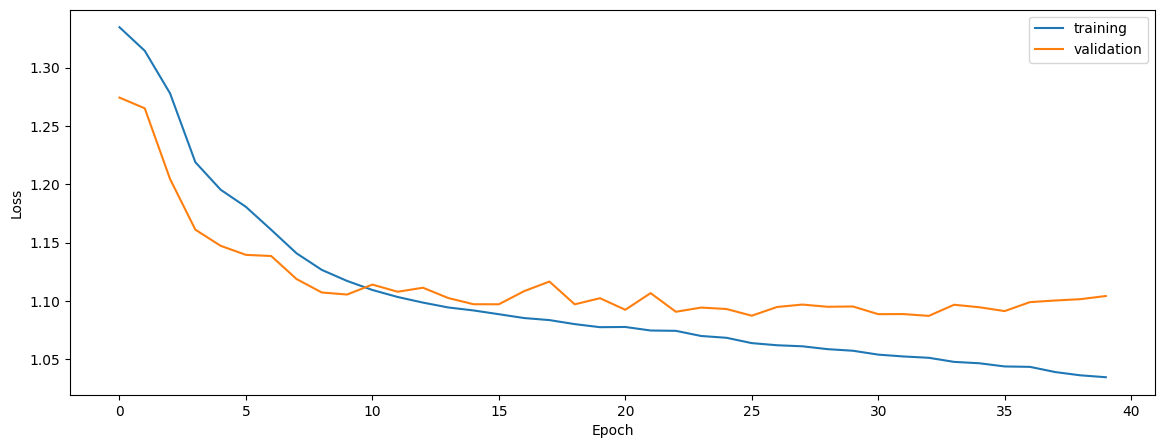

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


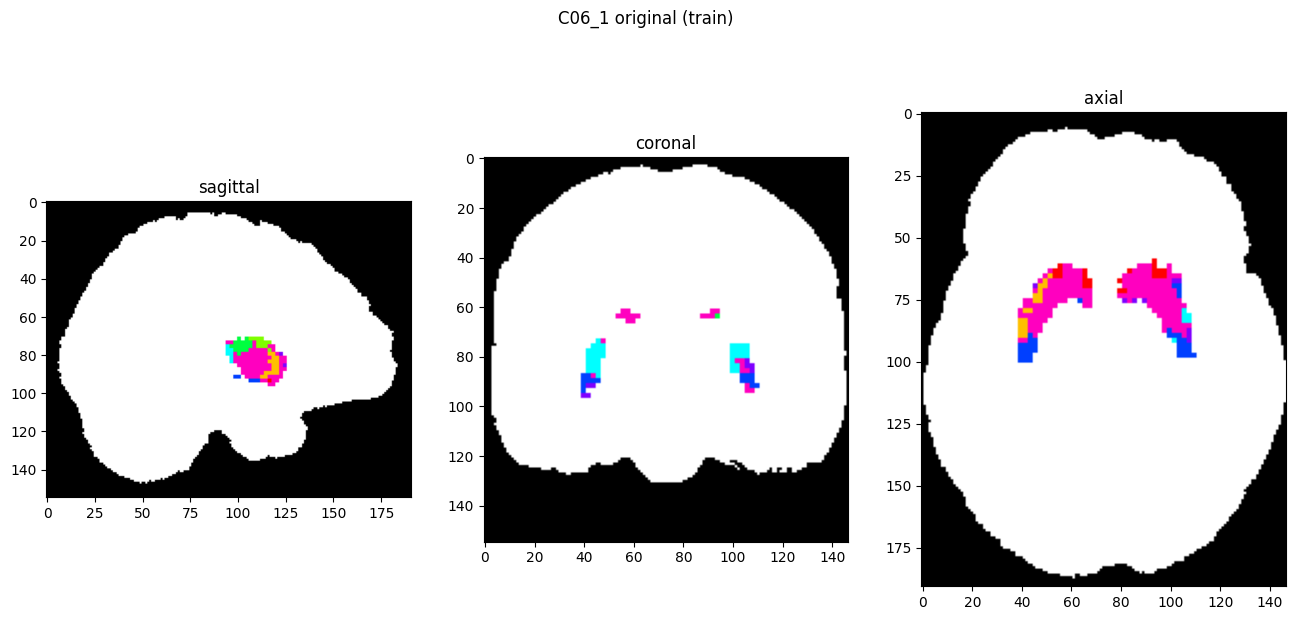

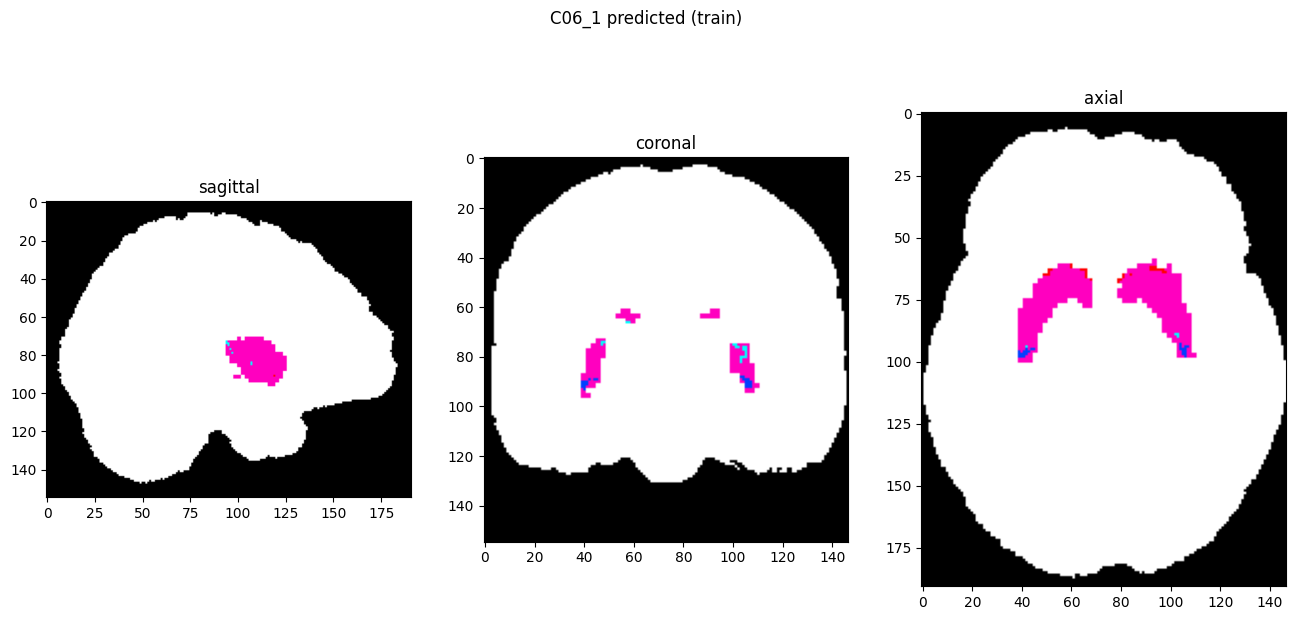

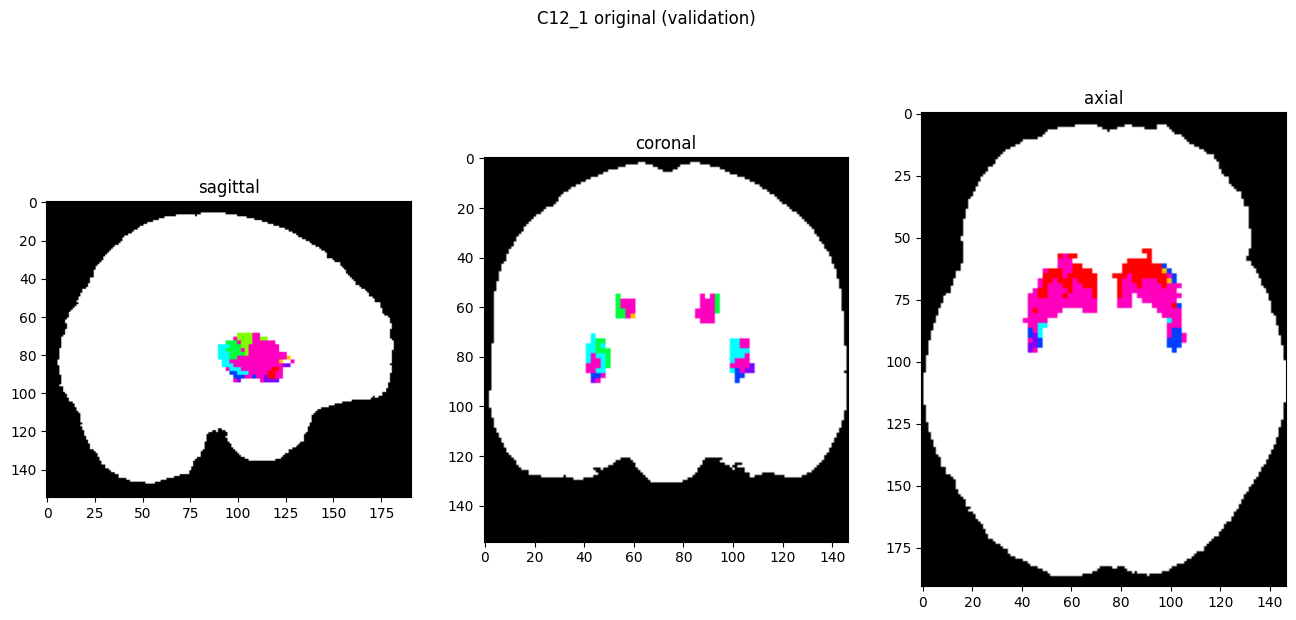

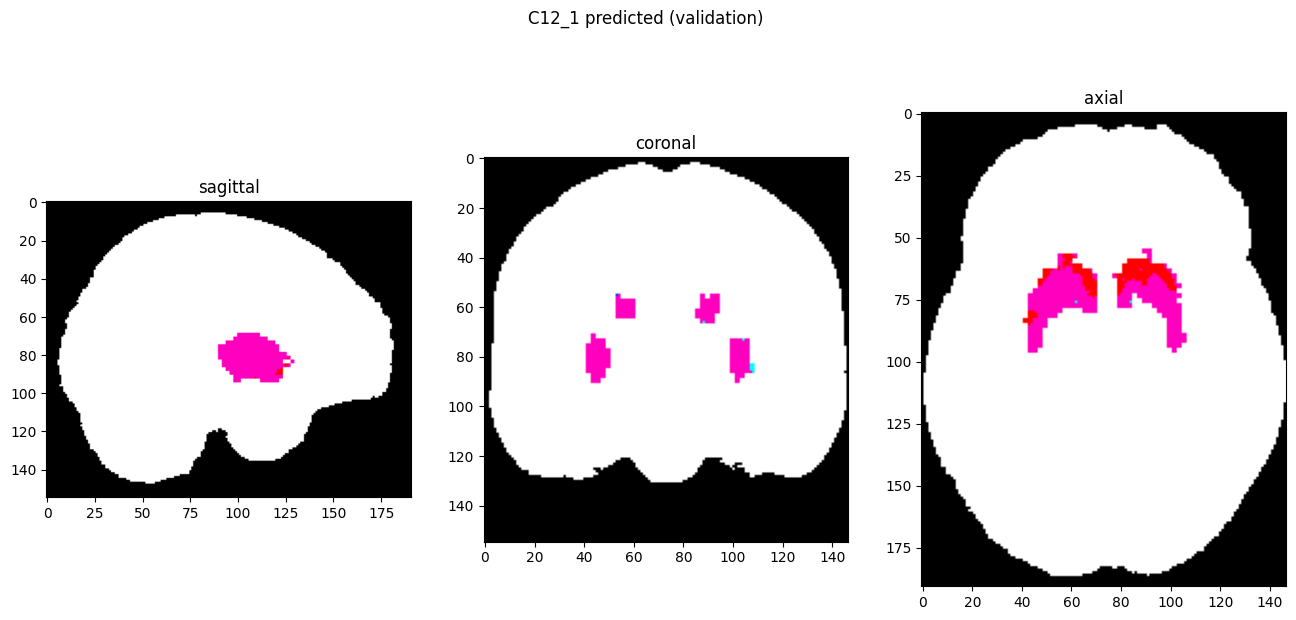

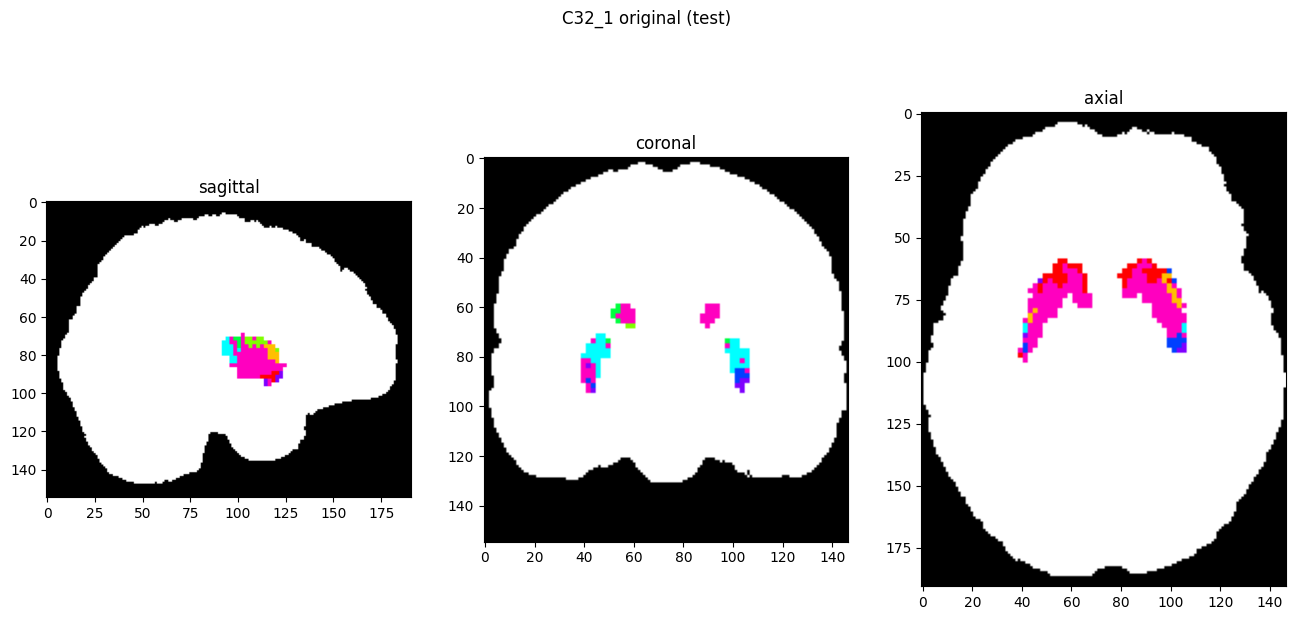

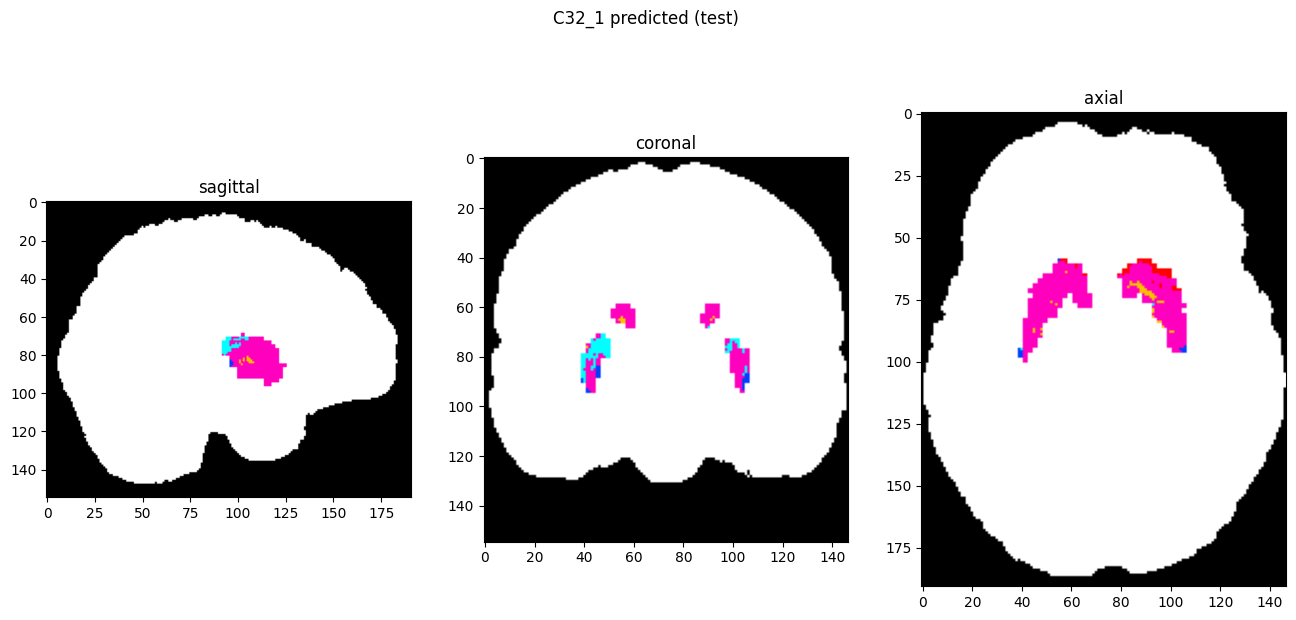

In [10]:
showResults(model, gen, threshold=0)